In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats
import random
%matplotlib inline 

In [2]:
plt.style.use('seaborn-poster')

# 1. Number of iterations

The target statistics will be:
- percentage of runs where the wave of infection is large enough - 5% of population is confirmed as infected
- percentage of rns where the wave of infections lasts the complete period of time (doesn't finish early)

In [3]:
iterExperiment = pd.read_csv('Experiments/1. Iterations experiment/iterations_experiment-table_3.csv', skiprows=6)

In [4]:
# clean up
cols = ['[run number]', '[step]', 'SusceptibleAgents', 'ExposedAgents', 'InfectedAAgents', 'InfectedMAgents', \
       'InfectedSAgents', 'InfectedCAgents', 'RecoveredAgents', 'DeadAgents', 'cumulativeConfirmedCases', \
        'cumulativeConfirmedRandomCases', 'cumulativeNegativeRandomCases']
iterExperiment = iterExperiment[cols]
iterExperiment.columns = cols = ['run_number', 'step', 'SusceptibleAgents', 'ExposedAgents', 'InfectedAAgents', 'InfectedMAgents', \
       'InfectedSAgents', 'InfectedCAgents', 'RecoveredAgents', 'DeadAgents', 'cumulativeConfirmedCases', 'cumulativeConfirmedRandomCases', 'cumulativeNegativeRandomCases']

In [5]:
# Find the last step of each run and keep the starting number of Susceptible agents
results = iterExperiment.groupby(['run_number'], as_index=False).agg({'step' : 'max', 'SusceptibleAgents' : 'max'})

# Then join on all the results for that step
results = results.merge(iterExperiment, how='left', on=['run_number', 'step'], suffixes=('_original', '_final'))

## 1.1 Full outbreak

In [6]:
def calcConfIntervals(p_hat, n, z=1.96):
    # n = number of runs
    # p_hat = proportion of runs that lead to target statistic
    # z defaults to 1.96 for 95% confidence interval
    lower = p_hat - (z *(np.sqrt((p_hat*(1 - p_hat)) / n)))
    upper = p_hat + (z * (np.sqrt((p_hat*(1 - p_hat)) / n)))
        
    return lower, upper

In [7]:
def genSamples(x, sample_size):
    sample_stats = []
    for i in range(5, sample_size + 1, 5):
        avg = np.mean(x[:i])
        lowerCI, upperCI = calcConfIntervals(avg, i)
        sample_stats.append([i, avg, lowerCI, upperCI])
    
    sample_stats = pd.DataFrame(sample_stats, columns=['runs', 'target_value', 'lowerCI', 'upperCI'])
    
    return sample_stats

In [8]:
results['full_outbreak'] = np.where(results['step'] >= 2300, 1, 0)

In [9]:
sample_stats = genSamples(results['full_outbreak'], 700)

Text(0, 0.5, 'Proportion of runs with a full outbreak')

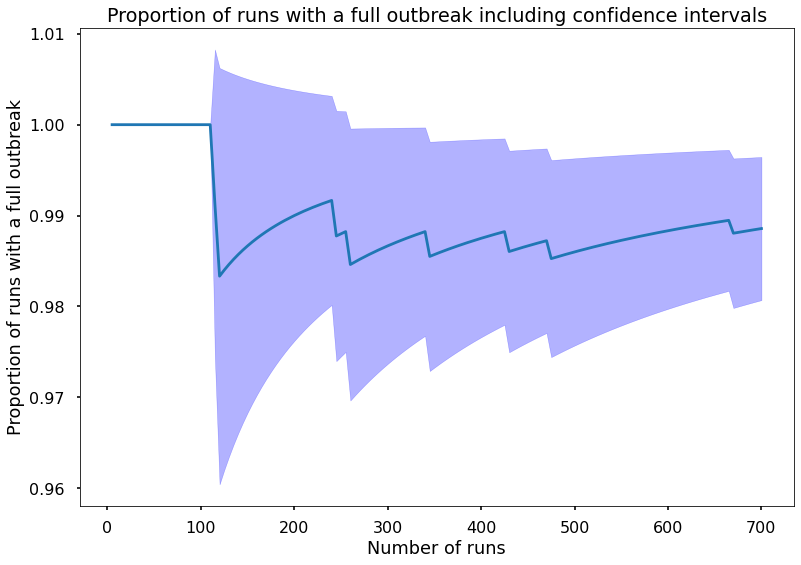

In [10]:
x = sample_stats['runs']
y = sample_stats['target_value']

fig, ax = plt.subplots()  # a figure with a single Axes

ax.plot(x, y)
ax.fill_between(x, y1=sample_stats['lowerCI'], y2=sample_stats['upperCI'], color='b', alpha=0.3)
ax.set_title('Proportion of runs with a full outbreak including confidence intervals')
ax.set_xlabel('Number of runs')
ax.set_ylabel('Proportion of runs with a full outbreak')

In [11]:
sample_stats[sample_stats['runs'].isin([5, 50, 100, 200, 300, 400, 500, 600, 700])]

,runs,target_value,lowerCI,upperCI
0,5,1.000000,1.000000,1.000000
9,50,1.000000,1.000000,1.000000
19,100,1.000000,1.000000,1.000000
39,200,0.990000,0.976210,1.003790
59,300,0.986667,0.973687,0.999646
79,400,0.987500,0.976612,0.998388
99,500,0.986000,0.975702,0.996298
119,600,0.988333,0.979741,0.996926
139,700,0.988571,0.980697,0.996446


In [12]:
#sample_stats[sample_stats['runs'] > 250].head(60)

In [13]:
#sample_stats[sample_stats['runs'] > 250].tail(60)

## 1.2 Outbreak size

In [14]:
results['S_percentage'] = results['cumulativeConfirmedCases'] / results['SusceptibleAgents_original']
results['large_outbreak'] = np.where(results['S_percentage'] >= 0.05, 1, 0)

In [15]:
x = np.array(results['large_outbreak'])

In [16]:
sample_stats = genSamples(results['large_outbreak'], 700)

Text(0, 0.5, 'Proportion of runs with a large outbreak')

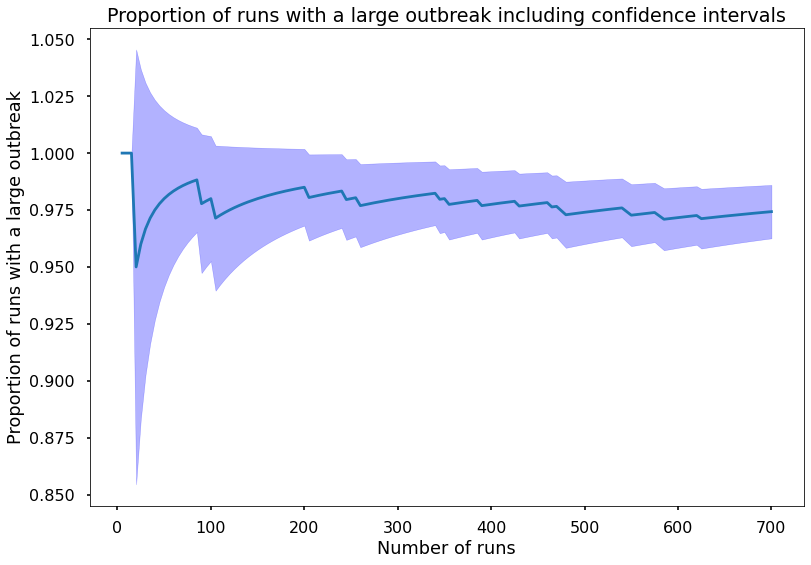

In [17]:
# Plot results
x = sample_stats['runs']
y = sample_stats['target_value']

fig, ax = plt.subplots()  # a figure with a single Axes

ax.plot(x, y)
ax.fill_between(x, y1=sample_stats['lowerCI'], y2=sample_stats['upperCI'], color='b', alpha=0.3)
ax.set_title('Proportion of runs with a large outbreak including confidence intervals')
ax.set_xlabel('Number of runs')
ax.set_ylabel('Proportion of runs with a large outbreak')

In [18]:
sample_stats[sample_stats['runs'].isin([5, 50, 100, 200, 300, 400, 500, 600, 700])]

,runs,target_value,lowerCI,upperCI
0,5,1.000000,1.000000,1.000000
9,50,0.980000,0.941194,1.018806
19,100,0.980000,0.952560,1.007440
39,200,0.985000,0.968154,1.001846
59,300,0.980000,0.964158,0.995842
79,400,0.977500,0.962966,0.992034
99,500,0.974000,0.960051,0.987949
119,600,0.971667,0.958390,0.984943
139,700,0.974286,0.962560,0.986011


In [19]:
#sample_stats[sample_stats['runs'] > 250].head(60)

In [20]:
#sample_stats.tail(60)

# 2. Cross Validation vs validated model 

## 2.1 Agent Based Model

In [3]:
cv = pd.read_csv('Experiments/2. Cross Validation/CrossValidationResults.csv', skiprows=6)

In [4]:
columns = ['run', 'step', 'SusceptibleAgents', 'ExposedAgents', 'InfectedAAgents', 'InfectedMAgents', \
           'InfectedSAgents', 'InfectedCAgents', 'RecoveredAgents', 'DeadAgents']

In [5]:
cv.columns = columns

In [6]:
# Data Cleaning
cv = cv.loc[cv['step'] > 0, :]

# Adding columns for simpler SEIR graphs
cv['TotalInfectedAgents'] = cv['InfectedAAgents'] + cv['InfectedCAgents'] + cv['InfectedMAgents'] + cv['InfectedSAgents']
cv ['Removed'] = cv['RecoveredAgents'] + cv['DeadAgents']
cv['days'] = cv['step'] // 24

### 2.1.1 Plot Agent based model

In [7]:
def my_plotter(data1, data2, param_dict={'linewidth' : 1}):
    """
    A helper function to make a graph.
    """
    ax = plt.subplot()
    out = ax.plot(data1, data2, **param_dict)
    return out

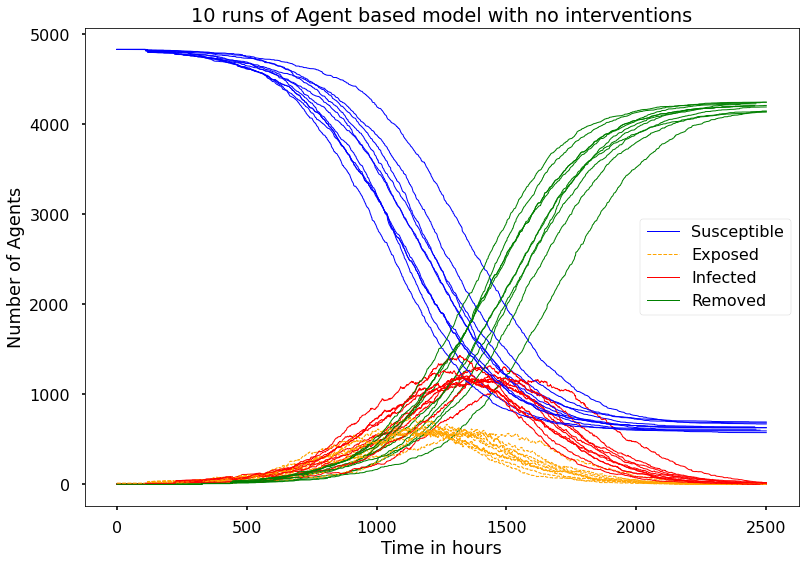

In [9]:
fig = plt.figure()  # an empty figure with no Axes
#fig, ax = plt.subplots()  # a figure with a single Axes

#ax.plot(cv.loc[cv['run'] == run, 'step'], cv.loc[cv['run'] == 2, 'SusceptibleAgents'], label='Susceptible', color='blue')

for run in cv['run'].unique():
    my_plotter(cv.loc[cv['run'] == run, 'step'], cv.loc[cv['run'] == run, 'SusceptibleAgents'], {'color' : 'blue', 'linewidth' : '1'})
    my_plotter(cv.loc[cv['run'] == run, 'step'], cv.loc[cv['run'] == run, 'ExposedAgents'], {'color' : 'orange', 'linewidth' : '1', 'linestyle' : '--'})
    my_plotter(cv.loc[cv['run'] == run, 'step'], cv.loc[cv['run'] == run, 'TotalInfectedAgents'], {'color' : 'red', 'linewidth' : '1'})
    my_plotter(cv.loc[cv['run'] == run, 'step'], cv.loc[cv['run'] == run, 'Removed'], {'color' : 'green', 'linewidth' : '1'})

# adding plots just for legend purposes 
my_plotter(cv.loc[cv['run'] == 1, 'step'], cv.loc[cv['run'] == 1, 'SusceptibleAgents'], {'color' : 'blue', 'linewidth' : '1', 'label' : 'Susceptible'})
my_plotter(cv.loc[cv['run'] == 1, 'step'], cv.loc[cv['run'] == 1, 'ExposedAgents'], {'color' : 'orange', 'linewidth' : '1', 'linestyle' : '--', 'label' : 'Exposed'})
my_plotter(cv.loc[cv['run'] == 1, 'step'], cv.loc[cv['run'] == 1, 'TotalInfectedAgents'], {'color' : 'red', 'linewidth' : '1', 'label' : 'Infected'})
my_plotter(cv.loc[cv['run'] == 1, 'step'], cv.loc[cv['run'] == 1, 'Removed'], {'color' : 'green', 'linewidth' : '1', 'label' : 'Removed'})
    
ax = plt.subplot()
ax.set_xlabel('Time in hours')
ax.set_ylabel('Number of Agents')
ax.set_title('10 runs of Agent based model with no interventions')
ax.legend()

## 2.2 Equation based model

In [10]:
from scipy.integrate import odeint

In [11]:
def deriv(y, t, N, beta, gamma, delta):
    S, E, I, R = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - delta * E
    dIdt = delta * E - gamma * I
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt

In [12]:
N = 4800
D = 10 #19.3 # infections last average of A=13.6, M=13.6, S=22.6, C=22.6, D=24.4
gamma = 1.0 / D
delta = 1.0 / 4.5  # incubation period (inverse of days exposed)
R_0 = 3.2
beta = R_0 * gamma  # R_0 = beta / gamma, so beta = R_0 * gamma
S0, E0, I0, R0 = N-10, 10, 0, 0  # initial conditions: 10 exposed

In [13]:
t = np.linspace(0, 200, 100) # Grid of time points (in days)
y0 = S0, E0, I0, R0 # Initial conditions vector

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta))
S, E, I, R = ret.T

### 2.2.1 Plot Equations based model

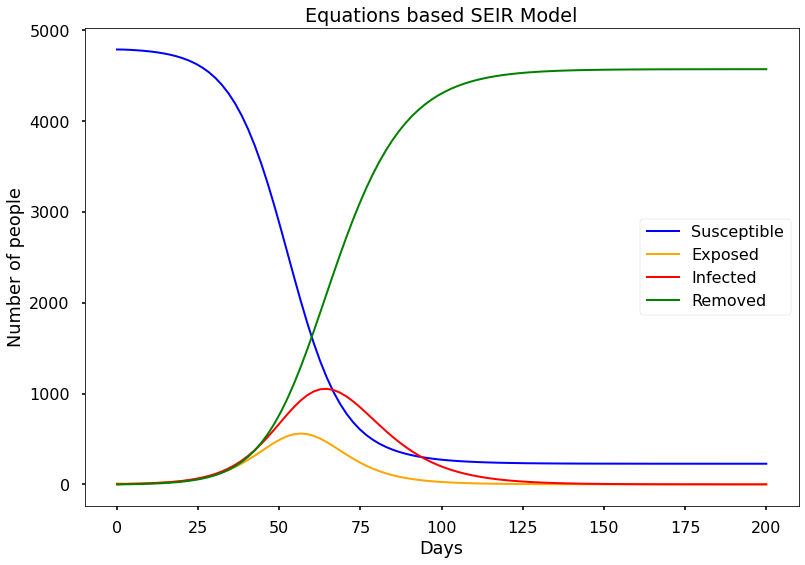

In [14]:
fig, ax = plt.subplots()

# Plot data
ax.plot(t, S, color='blue', linewidth=2, label='Susceptible')
ax.plot(t, E, color='orange', linewidth=2, label='Exposed')
ax.plot(t, I, color='red', linewidth=2, label = 'Infected')
ax.plot(t, R, color='green', linewidth=2, label='Removed')

# Add titles
ax.set_title('Equations based SEIR Model')
ax.set_xlabel('Days')
ax.set_ylabel('Number of people')
ax.legend()

## 2.3 Combined agent and equations based

In [16]:
#abmDays = cv.groupby(['days'], as_index=False).agg({'SusceptibleAgents' : 'mean', 'ExposedAgents' : 'mean', 'TotalInfectedAgents' : 'mean', 'Removed' : 'mean'})
abmDays = cv.groupby(['run', 'days'], as_index=False).agg({'SusceptibleAgents' : 'mean', 'ExposedAgents' : 'mean', 'TotalInfectedAgents' : 'mean', 'Removed' : 'mean'})

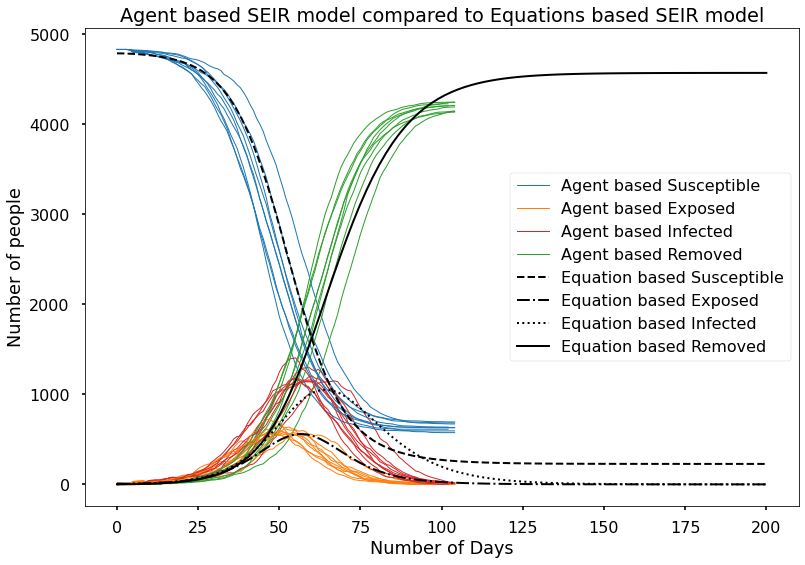

In [33]:
fig = plt.figure()  # an empty figure with no Axes
#fig, ax = plt.subplots()  # a figure with a single Axes

# Agent based plots - do one manually top get the legend, then all others in a loop
my_plotter(abmDays.loc[abmDays['run'] == 1, 'days'], abmDays.loc[abmDays['run'] == 1, 'SusceptibleAgents'], {'color' : 'tab:blue', 'linewidth' : '1', 'label' : 'Agent based Susceptible'})
my_plotter(abmDays.loc[abmDays['run'] == 1, 'days'], abmDays.loc[abmDays['run'] == 1, 'ExposedAgents'], {'color' : 'tab:orange', 'linewidth' : '1', 'label' : 'Agent based Exposed'})
my_plotter(abmDays.loc[abmDays['run'] == 1, 'days'], abmDays.loc[abmDays['run'] == 1, 'TotalInfectedAgents'], {'color' : 'tab:red', 'linewidth' : '1', 'label' : 'Agent based Infected'})
my_plotter(abmDays.loc[abmDays['run'] == 1, 'days'], abmDays.loc[abmDays['run'] == 1, 'Removed'], {'color' : 'tab:green', 'linewidth' : '1', 'label' : 'Agent based Removed'})

for run in range(2, len(cv['run'].unique())):
    my_plotter(abmDays.loc[abmDays['run'] == run, 'days'], abmDays.loc[abmDays['run'] == run, 'SusceptibleAgents'], {'color' : 'tab:blue', 'linewidth' : '1'})
    my_plotter(abmDays.loc[abmDays['run'] == run, 'days'], abmDays.loc[abmDays['run'] == run, 'ExposedAgents'], {'color' : 'tab:orange', 'linewidth' : '1'})
    my_plotter(abmDays.loc[abmDays['run'] == run, 'days'], abmDays.loc[abmDays['run'] == run, 'TotalInfectedAgents'], {'color' : 'tab:red', 'linewidth' : '1'})
    my_plotter(abmDays.loc[abmDays['run'] == run, 'days'], abmDays.loc[abmDays['run'] == run, 'Removed'], {'color' : 'tab:green', 'linewidth' : '1'})

# Equation based plots
my_plotter(t, S, {'color' : 'black', 'linestyle' : 'dashed', 'linewidth' : '2', 'label' : 'Equation based Susceptible'})
my_plotter(t, E, {'color' : 'black', 'linestyle' : 'dashdot', 'linewidth' : '2', 'label' : 'Equation based Exposed'})
my_plotter(t, I, {'color' : 'black', 'linestyle' : 'dotted', 'linewidth' : '2', 'label' : 'Equation based Infected'})
my_plotter(t, R, {'color' : 'black', 'linewidth' : '2', 'label' : 'Equation based Removed'})

# Add an axes for titles and legend
ax = plt.subplot()
ax.set_xlabel('Number of Days')
ax.set_ylabel('Number of people')
ax.set_title('Agent based SEIR model compared to Equations based SEIR model')
ax.legend()


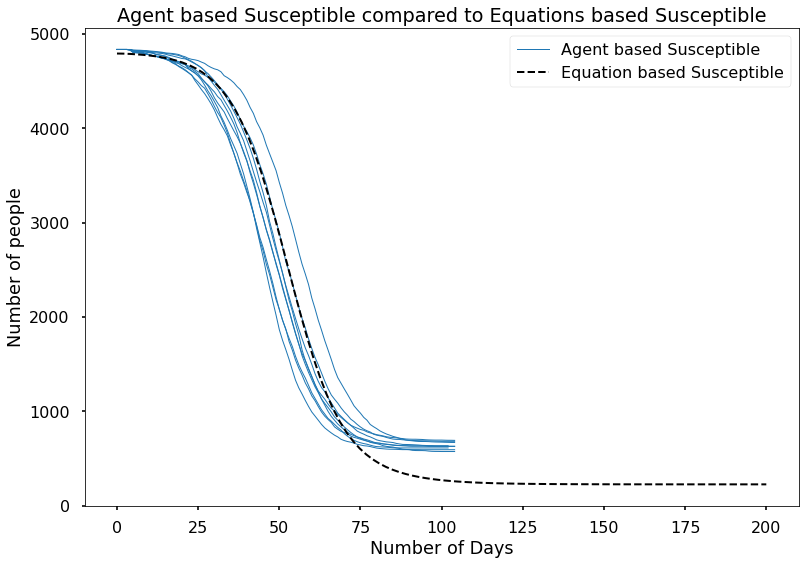

In [36]:
fig = plt.figure()  # an empty figure with no Axes
#fig, ax = plt.subplots()  # a figure with a single Axes

# Agent based plots - do one manually top get the legend, then all others in a loop
my_plotter(abmDays.loc[abmDays['run'] == 1, 'days'], abmDays.loc[abmDays['run'] == 1, 'SusceptibleAgents'], {'color' : 'tab:blue', 'linewidth' : '1', 'label' : 'Agent based Susceptible'})

for run in range(2, len(cv['run'].unique())):
    my_plotter(abmDays.loc[abmDays['run'] == run, 'days'], abmDays.loc[abmDays['run'] == run, 'SusceptibleAgents'], {'color' : 'tab:blue', 'linewidth' : '1'})

# Equation based plots
my_plotter(t, S, {'color' : 'black', 'linestyle' : 'dashed', 'linewidth' : '2', 'label' : 'Equation based Susceptible'})

# Add an axes for titles and legend
ax = plt.subplot()
ax.set_xlabel('Number of Days')
ax.set_ylabel('Number of people')
ax.set_title('Agent based Susceptible compared to Equations based Susceptible')
ax.legend()

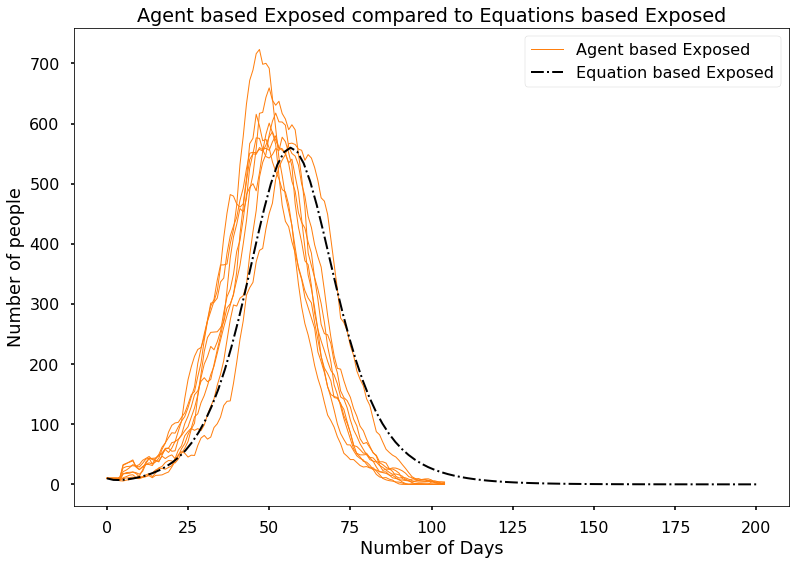

In [37]:
fig = plt.figure()  # an empty figure with no Axes
#fig, ax = plt.subplots()  # a figure with a single Axes

# Agent based plots - do one manually top get the legend, then all others in a loop
my_plotter(abmDays.loc[abmDays['run'] == 1, 'days'], abmDays.loc[abmDays['run'] == 1, 'ExposedAgents'], {'color' : 'tab:orange', 'linewidth' : '1', 'label' : 'Agent based Exposed'})

for run in range(2, len(cv['run'].unique())):
    my_plotter(abmDays.loc[abmDays['run'] == run, 'days'], abmDays.loc[abmDays['run'] == run, 'ExposedAgents'], {'color' : 'tab:orange', 'linewidth' : '1'})

# Equation based plots
my_plotter(t, E, {'color' : 'black', 'linestyle' : 'dashdot', 'linewidth' : '2', 'label' : 'Equation based Exposed'})

# Add an axes for titles and legend
ax = plt.subplot()
ax.set_xlabel('Number of Days')
ax.set_ylabel('Number of people')
ax.set_title('Agent based Exposed compared to Equations based Exposed')
ax.legend()

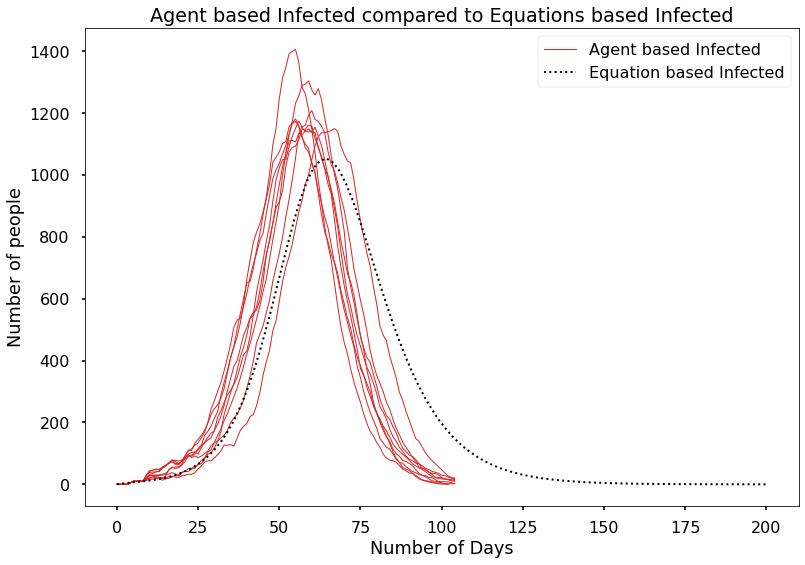

In [41]:
fig = plt.figure()  # an empty figure with no Axes
#fig, ax = plt.subplots()  # a figure with a single Axes

# Agent based plots - do one manually top get the legend, then all others in a loop
my_plotter(abmDays.loc[abmDays['run'] == 1, 'days'], abmDays.loc[abmDays['run'] == 1, 'TotalInfectedAgents'], {'color' : 'tab:red', 'linewidth' : '1', 'label' : 'Agent based Infected'})

for run in range(2, len(cv['run'].unique())):
    my_plotter(abmDays.loc[abmDays['run'] == run, 'days'], abmDays.loc[abmDays['run'] == run, 'TotalInfectedAgents'], {'color' : 'tab:red', 'linewidth' : '1'})

# Equation based plots
my_plotter(t, I, {'color' : 'black', 'linestyle' : 'dotted', 'linewidth' : '2', 'label' : 'Equation based Infected'})

# Add an axes for titles and legend
ax = plt.subplot()
ax.set_xlabel('Number of Days')
ax.set_ylabel('Number of people')
ax.set_title('Agent based Infected compared to Equations based Infected')
ax.legend()

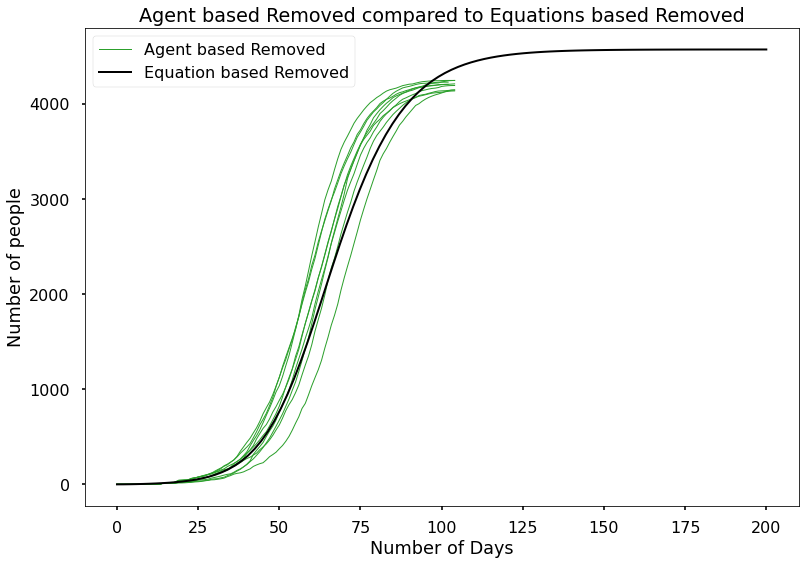

In [43]:
fig = plt.figure()  # an empty figure with no Axes
#fig, ax = plt.subplots()  # a figure with a single Axes

# Agent based plots - do one manually top get the legend, then all others in a loop
my_plotter(abmDays.loc[abmDays['run'] == 1, 'days'], abmDays.loc[abmDays['run'] == 1, 'Removed'], {'color' : 'tab:green', 'linewidth' : '1', 'label' : 'Agent based Removed'})

for run in range(2, len(cv['run'].unique())):
    my_plotter(abmDays.loc[abmDays['run'] == run, 'days'], abmDays.loc[abmDays['run'] == run, 'Removed'], {'color' : 'tab:green', 'linewidth' : '1'})

# Equation based plots
my_plotter(t, R, {'color' : 'black', 'linewidth' : '2', 'label' : 'Equation based Removed'})

# Add an axes for titles and legend
ax = plt.subplot()
ax.set_xlabel('Number of Days')
ax.set_ylabel('Number of people')
ax.set_title('Agent based Removed compared to Equations based Removed')
ax.legend()

## 2.4 Cross Validation

In [44]:
# Libraries
from scipy.stats import pearsonr
from scipy.stats import spearmanr

### 2.4.1 Data Prep

In [45]:
Sm = cv.groupby(['days'], as_index=False).agg({'SusceptibleAgents' : 'mean', 'ExposedAgents' : 'mean', 'TotalInfectedAgents' : 'mean', 'Removed' : 'mean'})

In [46]:
Sm = Sm.tail(-5) # exclude first rows

### 2.4.2 Calculate correlations

In [47]:
def calcCorr(x, y):
    p, pp = pearsonr(x, y)
    s, ps = spearmanr(x, y)    
    print('Pearson correlation = {} with p-value of {}'.format(p, pp))
    print('Spearman correlation = {} with p-value of {}'.format(s, ps))

In [48]:
calcCorr(S, Sm['SusceptibleAgents'].values)

Pearson correlation = 0.8741144766996932 with p-value of 1.6909983044008738e-32
Spearman correlation = 0.9983318331833182 with p-value of 3.375801102378947e-123


In [49]:
calcCorr(E, Sm['ExposedAgents'].values)

Pearson correlation = 0.24462108021996298 with p-value of 0.01417320378360658
Spearman correlation = 0.6591419141914191 with p-value of 8.93626960311416e-14


In [50]:
calcCorr(I, Sm['TotalInfectedAgents'].values)

Pearson correlation = 0.16060935882247418 with p-value of 0.11042577102948627
Spearman correlation = 0.5464730417413712 with p-value of 4.067304345897557e-09


In [51]:
calcCorr(R, Sm['Removed'].values)

Pearson correlation = 0.8253778236545893 with p-value of 4.525985897161275e-26
Spearman correlation = 0.9995258586363347 with p-value of 5.892907091617277e-150


# 3. Sensitivity Analysis

In [52]:
def prepData(df):
    # Subset columns
    cols = ['[run number]', 'lockdown_from_day_n', '[step]', 'SusceptibleAgents', 'ExposedAgents', \
            'InfectedAAgents', 'InfectedMAgents', 'InfectedSAgents', 'InfectedCAgents', 'RecoveredAgents', \
            'DeadAgents', 'cumulativeConfirmedCases', 'Close_contact_tracing', 'PCR_Testing', 'Reduce_transmissibility_to']
    df = df[cols]

    # rename some columns
    cols = ['run_number', 'lockdown_from_day_n', 'step', 'SusceptibleAgents', 'ExposedAgents', \
            'InfectedAAgents', 'InfectedMAgents', 'InfectedSAgents', 'InfectedCAgents', 'RecoveredAgents', \
            'DeadAgents', 'cumulativeConfirmedCases', 'Close_contact_tracing', 'PCR_Testing', 'Reduce_transmissibility_to']
    df.columns = cols
    
    # remove step 0
    df = df.loc[df['step'] > 0, :]
    
    # group I and R compartments
    df['InfectedAgents'] = df['InfectedAAgents'] + df['InfectedCAgents'] + df['InfectedMAgents'] + df['InfectedSAgents']
    df['RemovedAgents'] = df['RecoveredAgents'] + df['DeadAgents']
    
    return df

## 3.1 Lockdown from Day n

### 3.1.1 Data Prep

In [53]:
lockdownFromN = pd.read_csv('Experiments/4. Sensitivity Analysis/4.1 Sensitivity Analysis - lockdown-v1.csv', skiprows=6)

In [54]:
lockdownFromN = prepData(lockdownFromN)

In [55]:
lockdownGrouped = lockdownFromN.groupby(['lockdown_from_day_n', 'step'], as_index=False).agg({'SusceptibleAgents' : 'mean', 'ExposedAgents' : 'mean', 'InfectedAgents' : 'mean', 'RemovedAgents' : 'mean'})

### 3.1.2 Plot lockdown from day n 

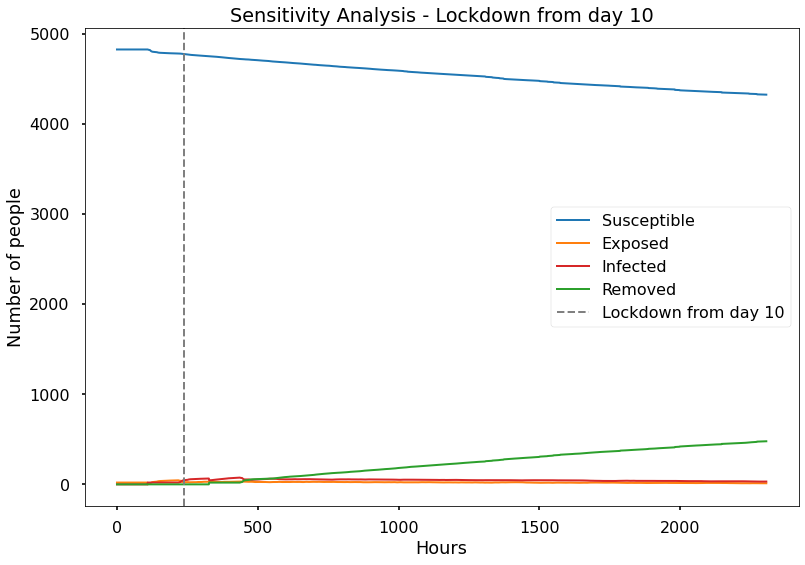

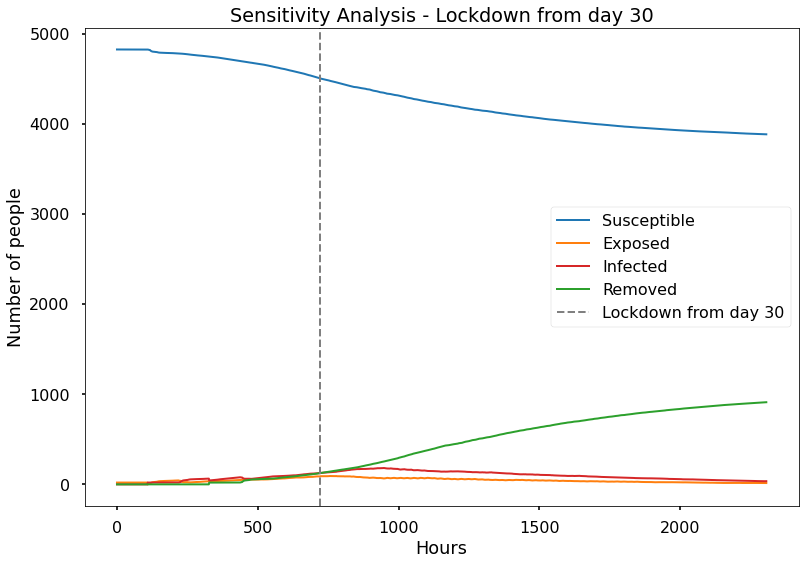

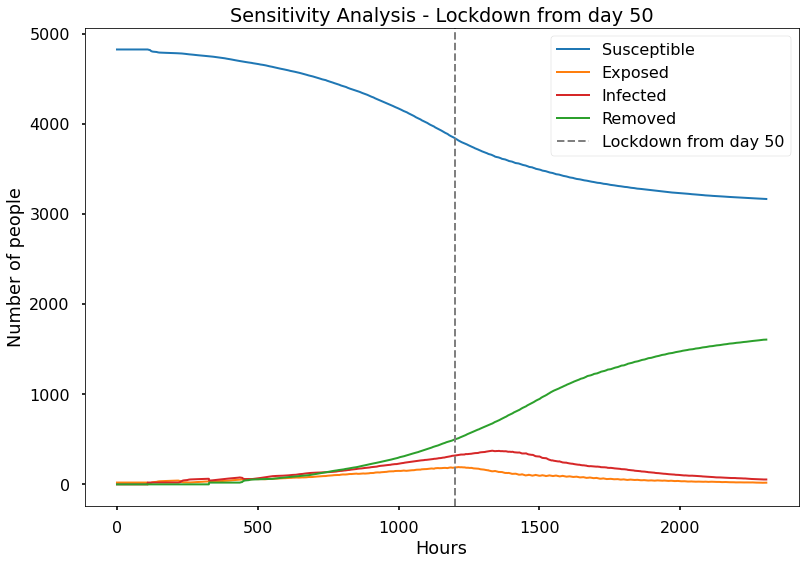

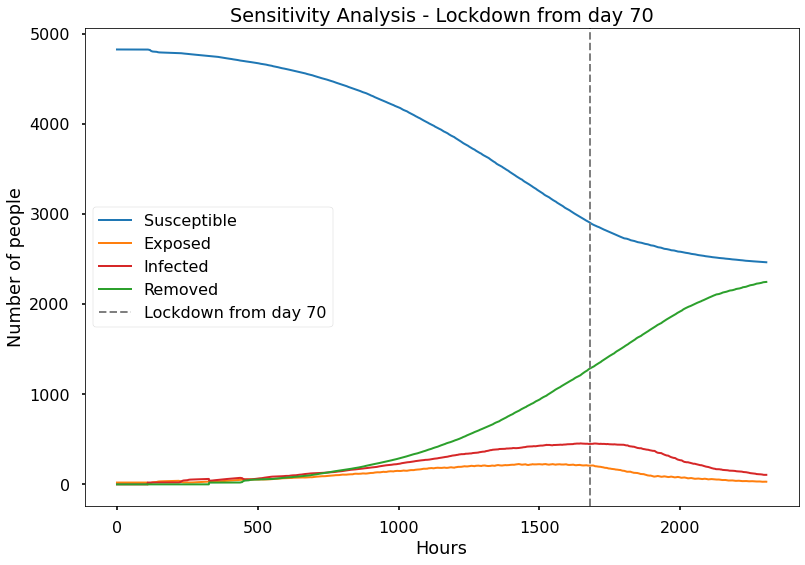

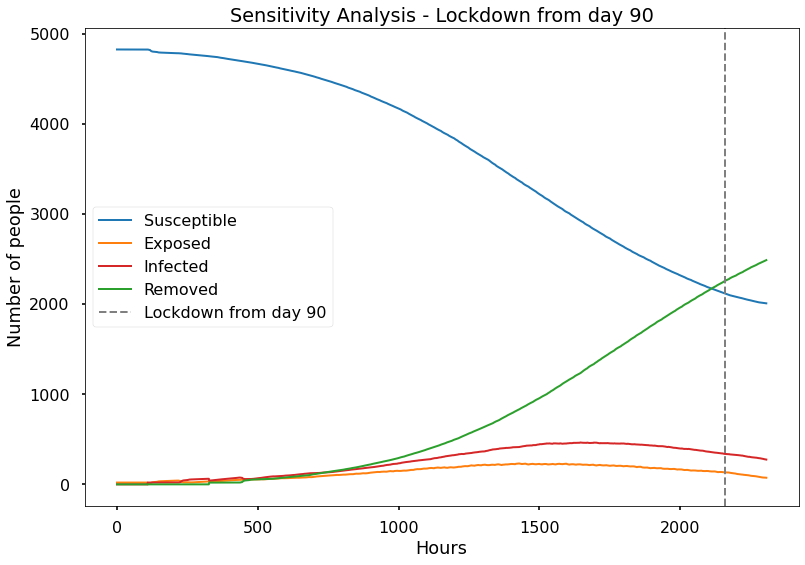

In [56]:
for n in [10, 30, 50, 70, 90]:
    fig, ax = plt.subplots()
    
    t = lockdownGrouped.loc[lockdownGrouped['lockdown_from_day_n'] == n, 'step']
    S = lockdownGrouped.loc[lockdownGrouped['lockdown_from_day_n'] == n, 'SusceptibleAgents']
    E = lockdownGrouped.loc[lockdownGrouped['lockdown_from_day_n'] == n, 'ExposedAgents']
    I = lockdownGrouped.loc[lockdownGrouped['lockdown_from_day_n'] == n, 'InfectedAgents']
    R = lockdownGrouped.loc[lockdownGrouped['lockdown_from_day_n'] == n, 'RemovedAgents']

    # Plot data
    ax.plot(t, S, color='tab:blue', linewidth=2, label='Susceptible')
    ax.plot(t, E, color='tab:orange', linewidth=2, label='Exposed')
    ax.plot(t, I, color='tab:red', linewidth=2, label = 'Infected')
    ax.plot(t, R, color='tab:green', linewidth=2, label='Removed')
    plt.axvline(x = n * 24, label='Lockdown from day {}'.format(n), color='grey', linewidth=2, linestyle='--')

    # Add titles
    ax.set_title('Sensitivity Analysis - Lockdown from day {}'.format(n))
    ax.set_xlabel('Hours')
    ax.set_ylabel('Number of people')
    ax.legend()
    plt.show()

### 3.1.3 Results table

In [57]:
lockdownGrouped[lockdownGrouped['lockdown_from_day_n'] == 50]

,lockdown_from_day_n,step,SusceptibleAgents,ExposedAgents,InfectedAgents,RemovedAgents
4610,50,1,4823.00,20.00,0.00,0.00
4611,50,2,4823.00,20.00,0.00,0.00
4612,50,3,4823.00,20.00,0.00,0.00
4613,50,4,4823.00,20.00,0.00,0.00
4614,50,5,4823.00,20.00,0.00,0.00
...,...,...,...,...,...,...
6910,50,2301,3165.45,18.88,53.79,1604.88
6911,50,2302,3165.07,19.13,53.81,1604.99
6912,50,2303,3164.97,19.00,53.97,1605.06
6913,50,2304,3164.91,18.87,54.00,1605.22


In [58]:
lockdownGrouped.groupby('lockdown_from_day_n', as_index=False).agg({'SusceptibleAgents' : 'last', 'ExposedAgents' : 'last', 'InfectedAgents' : 'last', 'RemovedAgents' : 'last'})

,lockdown_from_day_n,SusceptibleAgents,ExposedAgents,InfectedAgents,RemovedAgents
0,10,4321.974359,12.076923,31.025641,477.923077
1,30,3882.180000,14.610000,35.290000,910.920000
2,50,3164.860000,18.630000,54.010000,1605.500000
3,70,2463.130000,29.370000,105.530000,2244.970000
4,90,2007.710000,73.480000,274.970000,2486.840000


## 3.2 Testing and Tracing

### 3.2.1 Data prep

In [59]:
testAndTrace = pd.read_csv('Experiments/4. Sensitivity Analysis/4.2 Sensitivity Analysis - testing and tracing-v1.csv', skiprows=6)

In [60]:
testAndTrace = prepData(testAndTrace)

In [61]:
groupedTandT = testAndTrace.groupby(['Close_contact_tracing', 'PCR_Testing', 'step'], as_index=False).agg({'SusceptibleAgents' : 'mean', 'ExposedAgents' : 'mean', 'InfectedAgents' : 'mean', 'RemovedAgents' : 'mean'})

### 3.2.2 Plot data

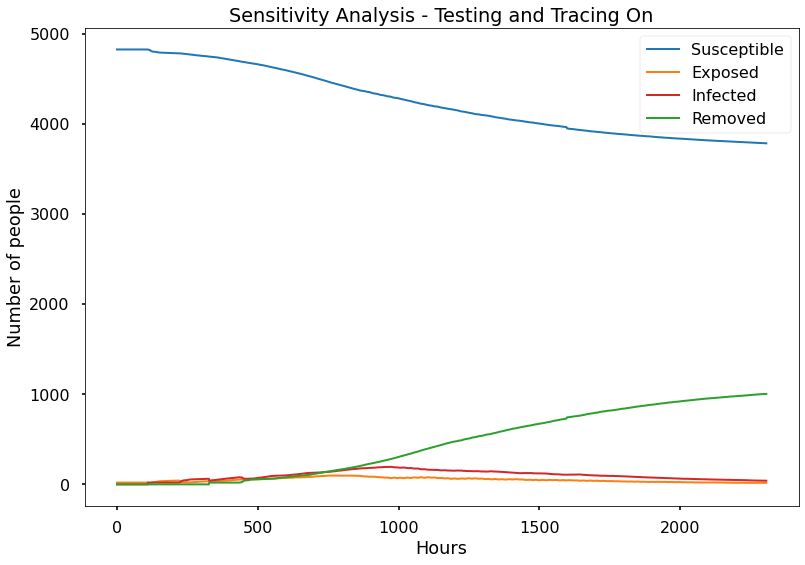

In [62]:
fig, ax = plt.subplots()
    
t = groupedTandT.loc[(groupedTandT['Close_contact_tracing'] == True) & (groupedTandT['PCR_Testing'] == True), 'step']
S = groupedTandT.loc[(groupedTandT['Close_contact_tracing'] == True) & (groupedTandT['PCR_Testing'] == True), 'SusceptibleAgents']
E = groupedTandT.loc[(groupedTandT['Close_contact_tracing'] == True) & (groupedTandT['PCR_Testing'] == True), 'ExposedAgents']
I = groupedTandT.loc[(groupedTandT['Close_contact_tracing'] == True) & (groupedTandT['PCR_Testing'] == True), 'InfectedAgents']
R = groupedTandT.loc[(groupedTandT['Close_contact_tracing'] == True) & (groupedTandT['PCR_Testing'] == True), 'RemovedAgents']

# Plot data
ax.plot(t, S, color='tab:blue', linewidth=2, label='Susceptible')
ax.plot(t, E, color='tab:orange', linewidth=2, label='Exposed')
ax.plot(t, I, color='tab:red', linewidth=2, label = 'Infected')
ax.plot(t, R, color='tab:green', linewidth=2, label='Removed')

# Add titles
ax.set_title('Sensitivity Analysis - Testing and Tracing On')
ax.set_xlabel('Hours')
ax.set_ylabel('Number of people')
ax.legend()
plt.show()

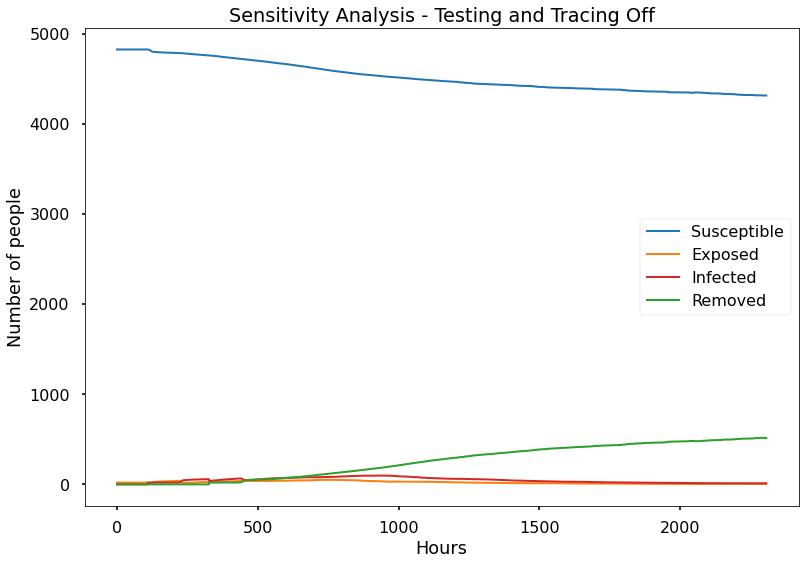

In [63]:
fig, ax = plt.subplots()
    
t = groupedTandT.loc[(groupedTandT['Close_contact_tracing'] == False) & (groupedTandT['PCR_Testing'] == False), 'step']
S = groupedTandT.loc[(groupedTandT['Close_contact_tracing'] == False) & (groupedTandT['PCR_Testing'] == False), 'SusceptibleAgents']
E = groupedTandT.loc[(groupedTandT['Close_contact_tracing'] == False) & (groupedTandT['PCR_Testing'] == False), 'ExposedAgents']
I = groupedTandT.loc[(groupedTandT['Close_contact_tracing'] == False) & (groupedTandT['PCR_Testing'] == False), 'InfectedAgents']
R = groupedTandT.loc[(groupedTandT['Close_contact_tracing'] == False) & (groupedTandT['PCR_Testing'] == False), 'RemovedAgents']

# Plot data
ax.plot(t, S, color='tab:blue', linewidth=2, label='Susceptible')
ax.plot(t, E, color='tab:orange', linewidth=2, label='Exposed')
ax.plot(t, I, color='tab:red', linewidth=2, label = 'Infected')
ax.plot(t, R, color='tab:green', linewidth=2, label='Removed')

# Add titles
ax.set_title('Sensitivity Analysis - Testing and Tracing Off')
ax.set_xlabel('Hours')
ax.set_ylabel('Number of people')
ax.legend()
plt.show()

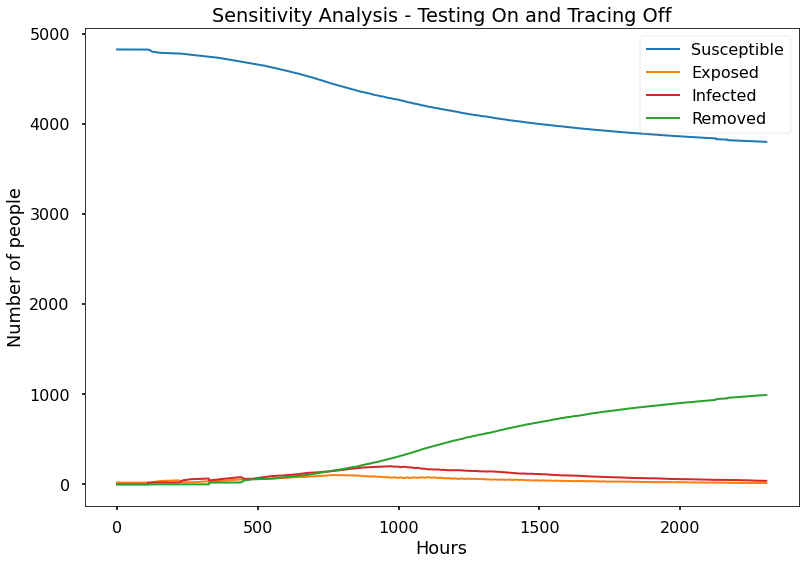

In [64]:
fig, ax = plt.subplots()
    
t = groupedTandT.loc[(groupedTandT['Close_contact_tracing'] == False) & (groupedTandT['PCR_Testing'] == True), 'step']
S = groupedTandT.loc[(groupedTandT['Close_contact_tracing'] == False) & (groupedTandT['PCR_Testing'] == True), 'SusceptibleAgents']
E = groupedTandT.loc[(groupedTandT['Close_contact_tracing'] == False) & (groupedTandT['PCR_Testing'] == True), 'ExposedAgents']
I = groupedTandT.loc[(groupedTandT['Close_contact_tracing'] == False) & (groupedTandT['PCR_Testing'] == True), 'InfectedAgents']
R = groupedTandT.loc[(groupedTandT['Close_contact_tracing'] == False) & (groupedTandT['PCR_Testing'] == True), 'RemovedAgents']

# Plot data
ax.plot(t, S, color='tab:blue', linewidth=2, label='Susceptible')
ax.plot(t, E, color='tab:orange', linewidth=2, label='Exposed')
ax.plot(t, I, color='tab:red', linewidth=2, label = 'Infected')
ax.plot(t, R, color='tab:green', linewidth=2, label='Removed')

# Add titles
ax.set_title('Sensitivity Analysis - Testing On and Tracing Off')
ax.set_xlabel('Hours')
ax.set_ylabel('Number of people')
ax.legend()
plt.show()

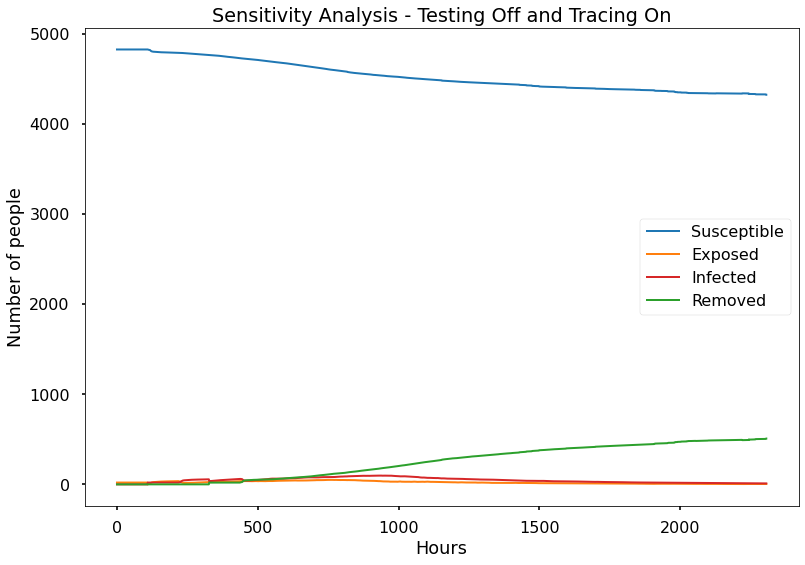

In [65]:
fig, ax = plt.subplots()
    
t = groupedTandT.loc[(groupedTandT['Close_contact_tracing'] == True) & (groupedTandT['PCR_Testing'] == False), 'step']
S = groupedTandT.loc[(groupedTandT['Close_contact_tracing'] == True) & (groupedTandT['PCR_Testing'] == False), 'SusceptibleAgents']
E = groupedTandT.loc[(groupedTandT['Close_contact_tracing'] == True) & (groupedTandT['PCR_Testing'] == False), 'ExposedAgents']
I = groupedTandT.loc[(groupedTandT['Close_contact_tracing'] == True) & (groupedTandT['PCR_Testing'] == False), 'InfectedAgents']
R = groupedTandT.loc[(groupedTandT['Close_contact_tracing'] == True) & (groupedTandT['PCR_Testing'] == False), 'RemovedAgents']

# Plot data
ax.plot(t, S, color='tab:blue', linewidth=2, label='Susceptible')
ax.plot(t, E, color='tab:orange', linewidth=2, label='Exposed')
ax.plot(t, I, color='tab:red', linewidth=2, label = 'Infected')
ax.plot(t, R, color='tab:green', linewidth=2, label='Removed')

# Add titles
ax.set_title('Sensitivity Analysis - Testing Off and Tracing On')
ax.set_xlabel('Hours')
ax.set_ylabel('Number of people')
ax.legend()
plt.show()

### 3.2.3 Results table

In [66]:
groupedTandT

,Close_contact_tracing,PCR_Testing,step,SusceptibleAgents,ExposedAgents,InfectedAgents,RemovedAgents
0,False,False,1,4823.000000,20.000000,0.000000,0.000000
1,False,False,2,4823.000000,20.000000,0.000000,0.000000
2,False,False,3,4823.000000,20.000000,0.000000,0.000000
3,False,False,4,4823.000000,20.000000,0.000000,0.000000
4,False,False,5,4823.000000,20.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
9215,True,True,2301,3783.000000,17.316327,39.969388,1002.714286
9216,True,True,2302,3782.714286,17.479592,40.071429,1002.734694
9217,True,True,2303,3782.673469,17.367347,40.183673,1002.775510
9218,True,True,2304,3782.571429,17.275510,40.234694,1002.918367


In [67]:
groupedTandT.groupby(['Close_contact_tracing', 'PCR_Testing'], as_index=False).agg({'SusceptibleAgents' : 'last', 'ExposedAgents' : 'last', 'InfectedAgents' : 'last', 'RemovedAgents' : 'last'})

,Close_contact_tracing,PCR_Testing,SusceptibleAgents,ExposedAgents,InfectedAgents,RemovedAgents
0,False,False,4312.508475,3.762712,11.932203,514.796610
1,False,True,3798.622449,14.653061,38.806122,990.918367
2,True,False,4320.606557,3.885246,10.508197,508.000000
3,True,True,3782.428571,17.275510,40.204082,1003.091837


## 3.3 Reduce Transmissibility to simulate public health measures
E.g. physical distancing, mask wearing, hand washing etc

### 3.3.1 Data prep

In [68]:
reduceTran = pd.read_csv('Experiments/4. Sensitivity Analysis/4.3 Sensitivity Analysis - reduce transmissibility-v1.csv', skiprows=6)

In [69]:
reduceTran = prepData(reduceTran)

In [70]:
groupedTrans = reduceTran.groupby(['Reduce_transmissibility_to' , 'step'], as_index=False).agg({'SusceptibleAgents' : 'mean', 'ExposedAgents' : 'mean', 'InfectedAgents' : 'mean', 'RemovedAgents' : 'mean'})

### 3.3.2 Plot data

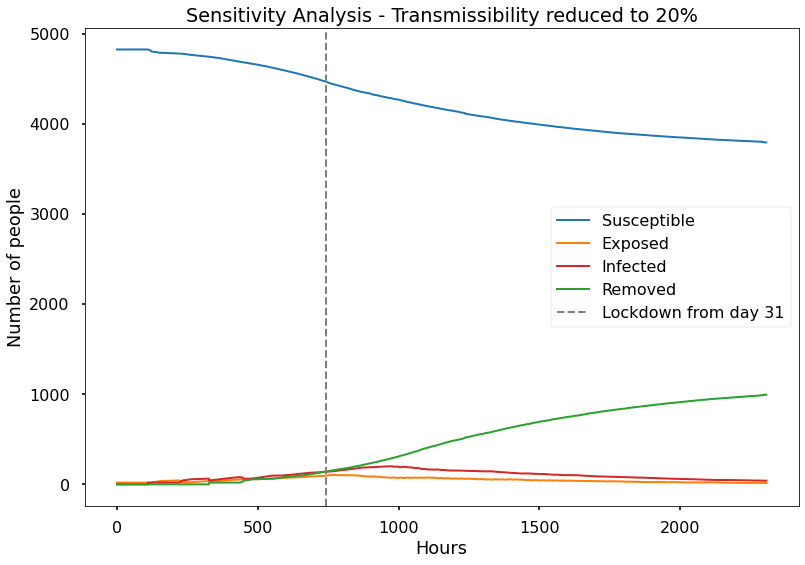

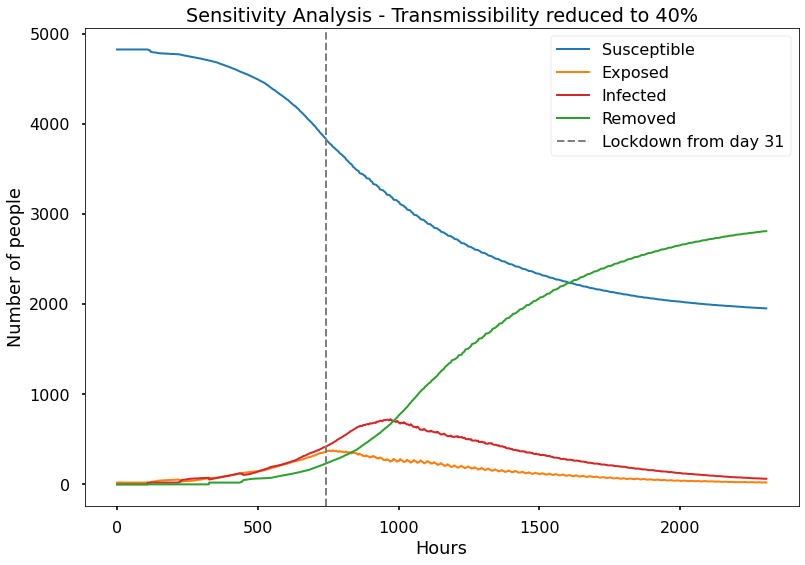

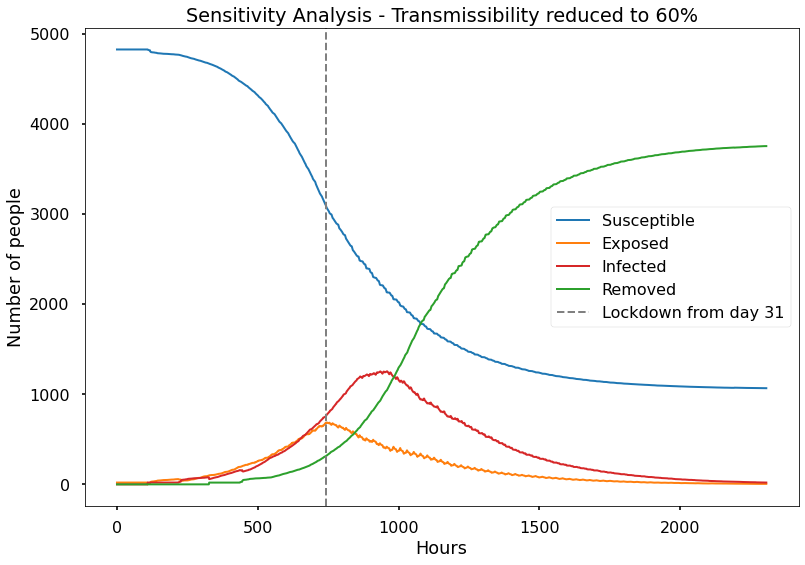

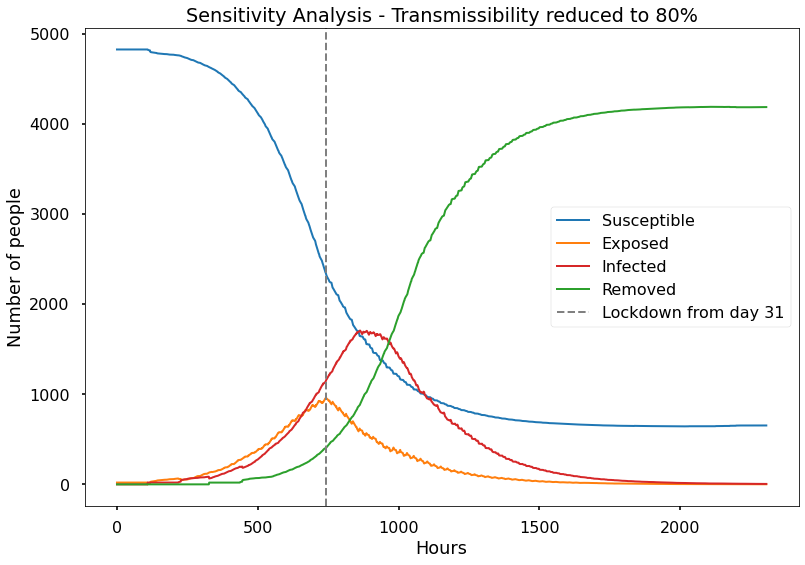

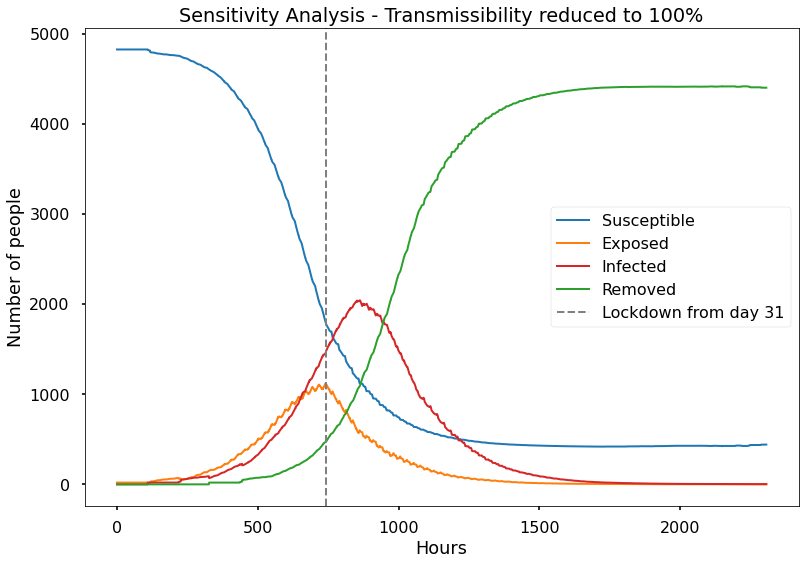

In [71]:
for n in [20, 40, 60, 80, 100]:
    fig, ax = plt.subplots()
    
    t = groupedTrans.loc[groupedTrans['Reduce_transmissibility_to'] == n, 'step']
    S = groupedTrans.loc[groupedTrans['Reduce_transmissibility_to'] == n, 'SusceptibleAgents']
    E = groupedTrans.loc[groupedTrans['Reduce_transmissibility_to'] == n, 'ExposedAgents']
    I = groupedTrans.loc[groupedTrans['Reduce_transmissibility_to'] == n, 'InfectedAgents']
    R = groupedTrans.loc[groupedTrans['Reduce_transmissibility_to'] == n, 'RemovedAgents']

    # Plot data
    ax.plot(t, S, color='tab:blue', linewidth=2, label='Susceptible')
    ax.plot(t, E, color='tab:orange', linewidth=2, label='Exposed')
    ax.plot(t, I, color='tab:red', linewidth=2, label = 'Infected')
    ax.plot(t, R, color='tab:green', linewidth=2, label='Removed')
    plt.axvline(x = 31 * 24, label='Lockdown from day 31', color='grey', linewidth=2, linestyle='--')

    # Add titles
    ax.set_title('Sensitivity Analysis - Transmissibility reduced to {}%'.format(n))
    ax.set_xlabel('Hours')
    ax.set_ylabel('Number of people')
    ax.legend()
    plt.show()

### 3.3.3 Results table

In [72]:
groupedTrans

,Reduce_transmissibility_to,step,SusceptibleAgents,ExposedAgents,InfectedAgents,RemovedAgents
0,20,1,4823.000000,20.000000,0.000000,0.000000
1,20,2,4823.000000,20.000000,0.000000,0.000000
2,20,3,4823.000000,20.000000,0.000000,0.000000
3,20,4,4823.000000,20.000000,0.000000,0.000000
4,20,5,4823.000000,20.000000,0.000000,0.000000
...,...,...,...,...,...,...
11520,100,2301,441.111111,0.518519,2.592593,4398.777778
11521,100,2302,441.111111,0.518519,2.592593,4398.777778
11522,100,2303,441.111111,0.518519,2.592593,4398.777778
11523,100,2304,441.111111,0.518519,2.555556,4398.814815


In [73]:
groupedTrans.groupby('Reduce_transmissibility_to', as_index=False).agg({'SusceptibleAgents' : 'last', 'ExposedAgents' : 'last', 'InfectedAgents' : 'last', 'RemovedAgents' : 'last'})

,Reduce_transmissibility_to,SusceptibleAgents,ExposedAgents,InfectedAgents,RemovedAgents
0,20,3792.357143,16.061224,40.693878,993.887755
1,40,1951.240000,21.630000,62.390000,2807.740000
2,60,1066.454545,5.252525,19.969697,3751.323232
3,80,653.082192,1.013699,4.739726,4184.164384
4,100,441.111111,0.407407,2.666667,4398.814815


# 4. Validate against Real World Data

##  4.1 Simulated data from NetLogo

In [3]:
simScenario = pd.read_csv('Experiments/3. Real world validation/3. Real world data validation-table_1.csv', skiprows=6)

In [4]:
# clean up
cols = ['[run number]', '[step]', 'SusceptibleAgents', 'ExposedAgents', 'InfectedAAgents', 'InfectedMAgents', \
       'InfectedSAgents', 'InfectedCAgents', 'RecoveredAgents', 'DeadAgents', 'cumulativeConfirmedCases', \
        'cumulativeConfirmedRandomCases', 'cumulativeNegativeRandomCases']
simScenario = simScenario[cols]

simScenario.columns = ['run', 'step', 'SusceptibleAgents', 'ExposedAgents', 'InfectedAAgents', 'InfectedMAgents', \
       'InfectedSAgents', 'InfectedCAgents', 'RecoveredAgents', 'DeadAgents', 'cumulativeConfirmedCases', \
        'cumulativeConfirmedRandomCases', 'cumulativeNegativeRandomCases']

In [5]:
simScenario['day'] = simScenario['step'] // 24

In [6]:
# exclude first 6 days
#simScenario = simScenario[simScenario['day'] >= 7]

In [7]:
simScenario

,run,step,SusceptibleAgents,ExposedAgents,InfectedAAgents,InfectedMAgents,InfectedSAgents,InfectedCAgents,RecoveredAgents,DeadAgents,cumulativeConfirmedCases,cumulativeConfirmedRandomCases,cumulativeNegativeRandomCases,day
0,3,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3,1,4823,20,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690475,300,2301,3868,15,19,29,2,0,906,4,534,0,0,95
690476,300,2302,3868,14,19,30,2,0,906,4,534,0,0,95
690477,300,2303,3868,14,19,30,2,0,906,4,534,0,0,95
690478,300,2304,3868,14,19,30,2,0,906,4,534,0,0,96


## 4.2 Real world outbreak data

In [8]:
real_world = pd.read_csv('dailycases.csv', header=None)

In [9]:
real_world.columns = ['dailycases']

In [10]:
# exclude last few days in November (data starts at Nov 24th)
real_world = real_world[7:]

## 4.3 T-test of real world data to simulated data (mean)

In [11]:
from scipy.stats import ttest_ind
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import mannwhitneyu
from scipy.stats import kstest

In [12]:
simAvg = simScenario.groupby(['day'], as_index=False).agg({'cumulativeConfirmedCases' : 'mean'})
simAvg['dailycases'] = simAvg['cumulativeConfirmedCases'].diff().fillna(0)

In [13]:
a = real_world

In [14]:
# Simulation is a sample of 4800 people out of a population of 56000 in County Carlow
# so the 
b = simAvg['dailycases'].values / 4843  #4800
b = b * 56932 #56000

In [15]:
b = simAvg['dailycases'].values * 4 # use different scaling factor to get closer results

In [16]:
b[:12] = 0

### 4.3.1 Test for normality and homogeneity of variance

In [17]:
shapiro(a)

ShapiroResult(statistic=0.6917244791984558, pvalue=2.2420682931761915e-12)

In [18]:
shapiro(b)

ShapiroResult(statistic=0.964242696762085, pvalue=0.009608236141502857)

In [19]:
# test for equal variance
levene(a.loc[:,'dailycases'], b)

LeveneResult(statistic=4.055914484150798, pvalue=0.04547351131170392)

### 4.3.2 Perform t-test

In [20]:
ttest_ind(a, b, axis=0, equal_var=False)

Ttest_indResult(statistic=array([0.31241121]), pvalue=array([0.75524817]))

In [21]:
mannwhitneyu(a.loc[:,'dailycases'], b)

MannwhitneyuResult(statistic=3585.0, pvalue=0.02310177000698875)

In [22]:
kstest(a.loc[:,'dailycases'], b)

KstestResult(statistic=0.28530059075639985, pvalue=0.0007564772478814152)

### 4.3.3 Plot

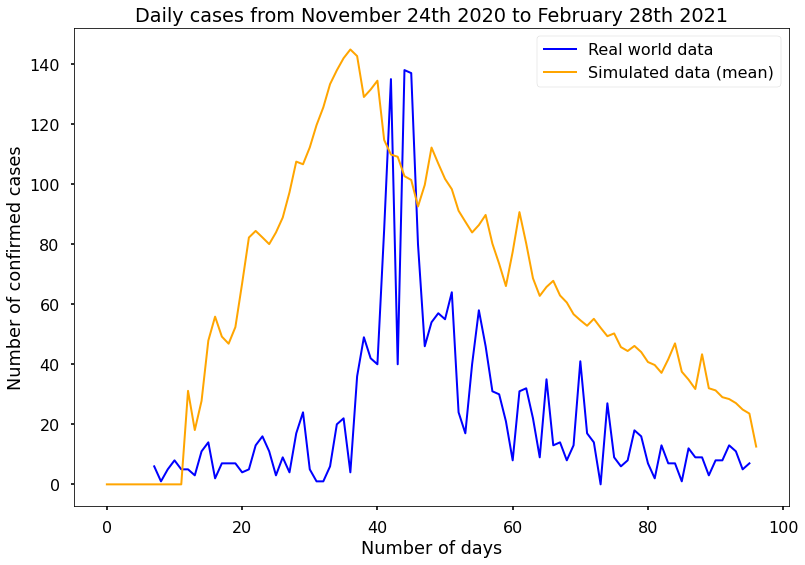

In [141]:
fig, ax = plt.subplots()

# Plot data
ax.plot(a, color='blue', linewidth=2, label='Real world data')
ax.plot(b, color='orange', linewidth=2, label='Simulated data (mean)')

# Add titles
ax.set_title('Daily cases from November 24th 2020 to February 28th 2021')
ax.set_xlabel('Number of days')
ax.set_ylabel('Number of confirmed cases')
ax.legend()

## 4.4 Correlation between real world and simulated data (mean)

In [158]:
calcCorr(a['dailycases'], b[:-8])

Pearson correlation = 0.6875529404940718 with p-value of 9.926885201129626e-14
Spearman correlation = 0.7278217933879536 with p-value of 6.486355879511379e-16


## 4.5 Distribution of daily cases

Does the real world data fall in the distribution of simulated data?

In [342]:
simRuns = simScenario.groupby(['run', 'day'], as_index=False).agg({'cumulativeConfirmedCases' : 'mean'})
simRuns['dailycases'] = simRuns['cumulativeConfirmedCases'].diff().fillna(0)
simRuns.loc[simRuns['dailycases'] < 0, 'dailycases'] = 0

In [343]:
simRuns.loc[simRuns['day'] < 12, 'dailycases'] = 0
simRuns.loc[simRuns['day'] < 12, 'cumulativeConfirmedCases'] = 0

In [344]:
simRuns.loc[simRuns['day'] >= 90, 'dailycases'] = 0
simRuns.loc[simRuns['day'] >= 90, 'cumulativeConfirmedCases'] = 0

In [331]:
# scale up the sample up to real world levels
simRuns['dailycases'] = simRuns['dailycases'] / 4843 #4800
simRuns['dailycases'] = simRuns['dailycases'] * 56932 #56000

In [345]:
simRuns['dailycases'] = simRuns['dailycases'] * 4 #56000

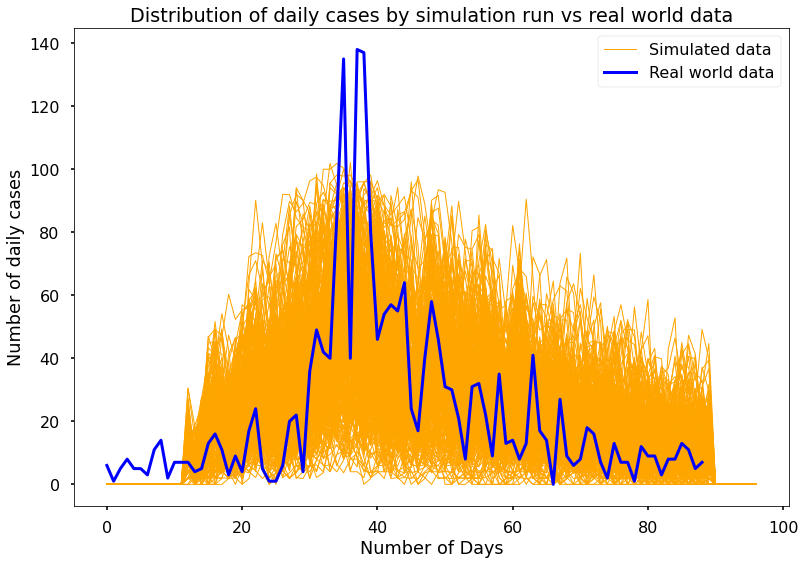

In [346]:
fig = plt.figure()  # an empty figure with no Axes
for run in simRuns['run'].unique():
    my_plotter(simRuns.loc[simRuns['run'] == run, 'day'], simRuns.loc[simRuns['run'] == run, 'dailycases'], {'color' : 'orange', 'linewidth' : '1'})

my_plotter(simRuns.loc[simRuns['run'] == 1, 'day'], simRuns.loc[simRuns['run'] == 1, 'dailycases'], {'color' : 'orange', 'linewidth' : '1', 'label' : 'Simulated data'})
my_plotter(range(0, len(real_world['dailycases']), 1), real_world['dailycases'], {'color' : 'blue', 'linewidth' : '3', 'label' : 'Real world data'})

# Add an axes for titles and legend
ax = plt.subplot()
ax.set_xlabel('Number of Days')
ax.set_ylabel('Number of daily cases')
ax.set_title('Distribution of daily cases by simulation run vs real world data')
ax.legend()

In [347]:
x = simRuns.groupby(['run'], as_index=False).agg({'dailycases' : 'sum'})

In [348]:
y = real_world.sum()

In [369]:
y

dailycases    2034.0
dtype: float64

In [368]:
shapiro(x['dailycases'])

ShapiroResult(statistic=0.9918950200080872, pvalue=0.09988213330507278)

<AxesSubplot:>

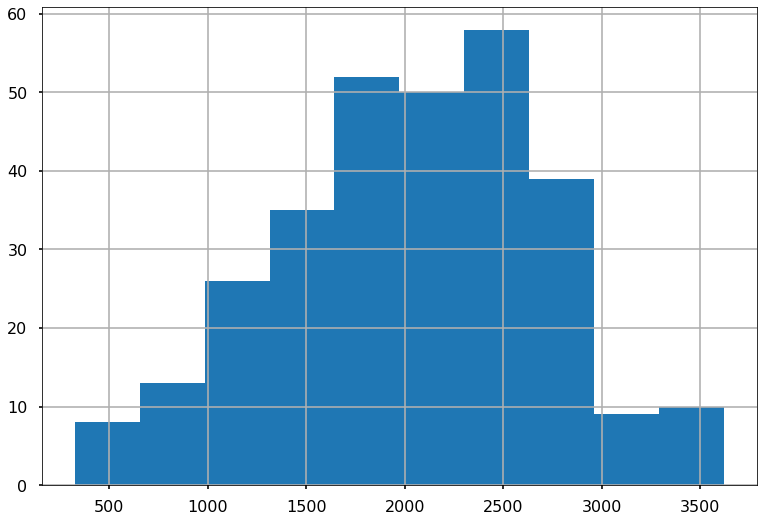

In [349]:
x['dailycases'].hist()

In [350]:
z = (y - x['dailycases'].mean()) / x['dailycases'].std()
print(z)

dailycases   -0.008811
dtype: float64


In [351]:
from scipy.stats import norm
from scipy.stats import boxcox

In [352]:
norm.sf(abs(z)) * 2

array([0.9929699])

In [353]:
np.percentile(x['dailycases'], [75, 25])

array([2483.16666667, 1590.41666667])